In [57]:
library("TSP")
concorde_path("~/concorde/TSP")




dataETSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/mu1979.tsp")


found: concorde concorde.c concorde.o 


In [58]:
start_time <- Sys.time()
dataTSP <- as.TSP(dataETSP)
concorde_tour<- solve_TSP(dataTSP, method="concorde")
end_time <- Sys.time()
concorde_time <- end_time - start_time
concorde_result <- tour_length(concorde_tour,dataETSP)
print("processing time")
concorde_time
print("tour_length")
concorde_result

plot(dataETSP, concorde_tour)

Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


In [8]:
concorde_result <-86882.6
concorde_time <- "Time difference of 41.54333 mins"

In [3]:
#function library

dist_pts <- function(pt1,pt2){
        return(sqrt((pt1[[1]]-pt2[[1]])^2 + (pt1[[2]]-pt2[[2]])^2))
}

angle <- function(x,y){
  dot.prod <- x%*%y 
  norm.x <- norm(x,type="2")
  norm.y <- norm(y,type="2")
  theta <- acos(dot.prod / (norm.x * norm.y))
  as.numeric(theta)
}

angle_pts <- function(pt1,pt2){
    
    if (pt1[[2]] -pt2[[2]] == 0){
        if (pt1[[1]] -pt2[[1]]>0){
            return(pi/2)
        }
        if (pt1[[1]] -pt2[[1]]<0){
            return(-pi/2)
        }
        if (pt1[[1]] -pt2[[1]]==0){
            return(0)
        }
    } else{
        x<- pt1[[1]] -pt2[[1]]
        y <-pt1[[2]] -pt2[[2]]
        angle <- atan((y)/(x))
        if (x < 0 & y>0){
            angle <- pi + angle
        }
        if (x >0 & y <0){
            angle <-2*pi +angle
        }
        if (x < 0 & y<0){
            angle <- pi + angle
        }
        return(angle)
        }
}


get_item <- function(item_to_get, database){
    counter <-1
    cont <- TRUE 
    while (counter <= length(database) & cont == TRUE){
        data_pt <-database[[counter]]
        if (data_pt[1] == item_to_get){
            return(data_pt)
            cont <- FALSE
        }
        counter <- counter +1
    }
}

get_pts_range_hor<- function(lower_bound, higher_bound, database){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(database) & cont ==TRUE){
        value <- database[[counter]]
        
        if (value[[2]] >= lower_bound & value[[2]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, value[[1]])
        }
        if (value[[2]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}


get_pts_range_vert<- function(lower_bound, higher_bound, database){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(database) & cont ==TRUE){
        value <- database[[counter]]
        
        if (value[[3]] >= lower_bound & value[[3]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, value[[1]])
        }
        if (value[[3]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}


get_possible_pts <- function(x_current,y_current,radius, horizontal_based, vertical_based, done){
    horizontal_eligible <- get_pts_range_hor(x_current - 2*radius, x_current + 2*radius, horizontal_based)
    vertical_eligible <- get_pts_range_vert(y_current - 2*radius, y_current + 2*radius, vertical_based)

    
    eligible <- intersect(horizontal_eligible, vertical_eligible)
    eligible<- eligible[!eligible %in% done]
    
    return(eligible)
}


add_data_mat <- function(cluster1_pos,cluster2_pos,value, mat){
    position1 <- (cluster1_pos -1)*nrow(mat) + cluster2_pos
    position2 <- (cluster2_pos -1)*nrow(mat) + cluster1_pos
    mat[[position1]] <- value
    mat[[position2]] <- value
    return(mat)
}


choose_new_edge <- function(forward_edge, backward_edge, main){

    f_vertex <- forward_edge[[2]]
    b_vertex <- backward_edge[[1]]
    
    common <- forward_edge[[1]]
    compare <- current_tree[[main]]
    
    f_min <- Inf
    f_replace <- NULL
    b_min <- Inf
    b_replace <- NULL
    
    vPt_f <-values(pointSet, keys=f_vertex) 
    vPt_b <-values(pointSet, keys=b_vertex) 
    
    
    for (vertex in compare){
        vPt_c <-values(pointSet, keys =vertex)
        if (vertex != common){
            
            if (f_min == Inf){
                f_min <- dist_pts(vPt_f , vPt_c)
                b_min <- dist_pts(vPt_b, vPt_c)
                f_replace<-vertex
                b_replace<-vertex
                
                
            } else {
                dist_f <-dist_pts(vPt_f , vPt_c) 
                if (dist_f < f_min){
                    f_min <- dist_f
                    f_replace <- vertex
                } 
                
                dist_b <- dist_pts(vPt_b , vPt_c)
                if (dist_b < b_min){
                    b_min <- dist_b
                    b_replace <- vertex
                }
            }  
        }
    }
    
    if (f_min <= b_min){
        return(list("f", f_replace))
    } else {
        return(list("b", b_replace))
    }
    
}

end_points_det <- function(cluster_tour, connections){
    merge <- hash()
    for (pt_index in 1:length(cluster_tour)){
        main <-cluster_tour[[pt_index]]
        
        if (pt_index == length(cluster_tour)){
            forward <- cluster_tour[[1]]
            backward <- cluster_tour[[pt_index - 1]]
            
        } else {
            if (pt_index == 1){
                forward <- cluster_tour[[pt_index+1]]
                backward <- cluster_tour[[length(cluster_tour)]]

                
            } else {
                forward <- cluster_tour[[pt_index+1]]
                backward <-cluster_tour[[pt_index-1]]

                }
        }
        forward_edge <- connections[[sprintf("%s-%s",main, forward)]]
        backward_edge <- connections[[sprintf("%s-%s",backward, main)]]
        
        if (forward_edge[[1]] == backward_edge[[2]]){
            if (length(current_tree[[main]]) != 1){
                compare_result <-  choose_new_edge(forward_edge, backward_edge, main)
                if (compare_result[[1]] == "f"){
                    forward_edge[[1]] <- compare_result[[2]]
                    
                } else {
                    backward_edge[[2]] <- compare_result[[2]]
                } 
            }
        } 
        merge[[toString(main)]] <-list(backward_edge[[2]],forward_edge[[1]] )
     
    }
    return(merge)
}

add_end_points <- function(tsp, end_points){
    constant <- rep(c(Inf), nrow(as.matrix(tsp)) )
    constant[[end_points[[1]]]] <- 0
    constant[[end_points[[2]]]] <- 0
    tsp <-insert_dummy(tsp, 1, const =constant, inf = Inf, label = "dummy")
    return(tsp)
}


to_global <- function(tour_list, main){
        
        for (tour_index in 1:length(tour_list)){
                for (vertex_index in 1:length(tour_list[[tour_index]])){
                        vertex <- as.integer(tour_list[[tour_index]][vertex_index])
                       
                        tour_list[[tour_index]][vertex_index] <- main[[tour_index]][vertex]
                }
        }
        return(tour_list)
}

filter_before_merge <- function(tour_list, end_points_list){
    for (index in 1:length(tour_list)){
        sol <- tour_list[[index]]
        sol <- sol [lengths(sol) != 0]
        old <- length(sol)
        start <- end_points_list[[toString(index)]][[1]]
        end <- end_points_list[[toString(index)]][[2]]
        start_pos <- match(start, sol)
        end_pos <- match(end, sol)

        if (start_pos < end_pos){
            if (start_pos != 1 | end_pos != length(sol)){
                sol <- append(rev(sol[1:start_pos]), rev(sol[end_pos:length(sol)]))
            } 
            
        } else {
            if (start_pos == length(sol) & end_pos == 1){
                sol <- rev(sol)
            } else {
                sol <- append(rev(sol[1:end_pos]), rev(sol[start_pos:length(sol)]))
                sol <- rev(sol)
             }
        }

        if(old != length(sol)){
            print("length mismatch, error occured in formatting")
            print("number of missing elements")
            print(old - length(sol))
        }
        
        tour_list[[index]] <- sol
    }
    return(tour_list)
} 

merge_all <- function(formatted_all_subtours, cluster_tour){
    merged_tour <- list()
    for (branch in cluster_tour){
        merged_tour <- append(merged_tour, all_subtours[[branch]])
    }
    print(as.integer(merged_tour))
    return(as.integer(merged_tour))
}


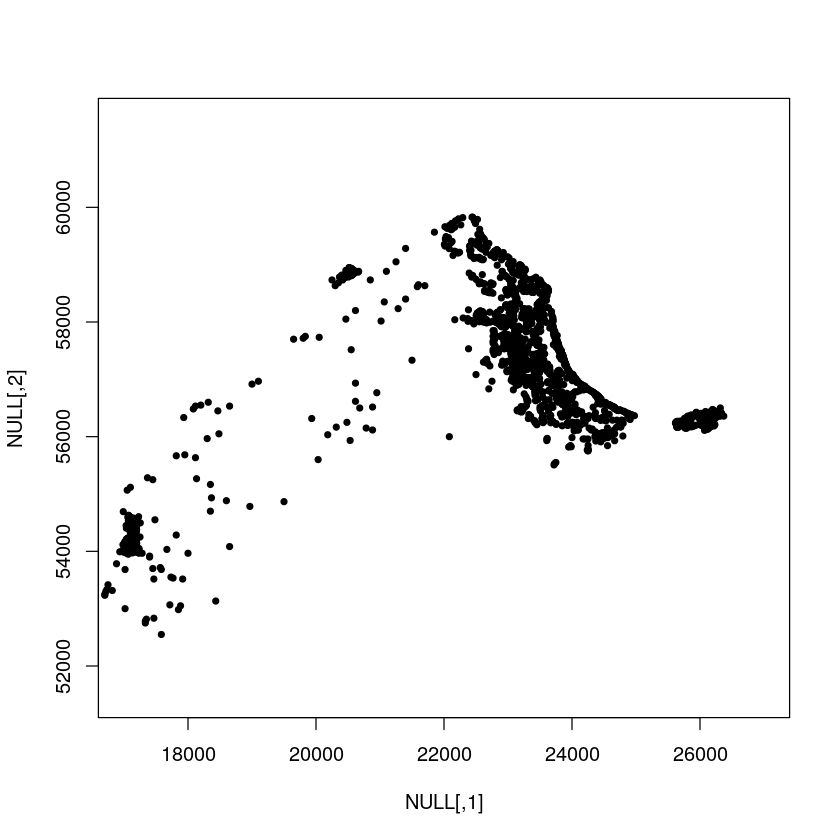

In [51]:
library("hash")
library("sets")

pointSet <- hash()
noPts <- length(dataETSP)/2
horizontal_based <- list()
vertical_based <-list()


radius <- 23
plot(dataETSP,xlim=c(17000,27000), ylim=c(51500,61500), pch=20)
symbols(dataETSP, circles=rep(radius,noPts), add=T, inches=F)

In [52]:
print("preparing necessary data")
start_time <- Sys.time()
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataETSP[i], dataETSP[i+noPts])
    element <- list(i, dataETSP[[i]],dataETSP[[i+noPts]])
    horizontal_based <- append( horizontal_based, list(element))
    vertical_based <- append(vertical_based, list(element))
}

horizontal_based <- horizontal_based[order(sapply(horizontal_based, '[[', 2))]
vertical_based <- vertical_based[order(sapply(vertical_based,'[[',3))]
vertices_mat <- as.matrix(as.TSP(dataETSP))
done <- list 
current_tree <- list()
checklist <-(c(1:noPts))


end_time <-Sys.time()
print("total time to pre process data")
add<- end_time - start_time
total<-  add
print(add)
print("begin clustering vertices based on given radius")
start_time <- Sys.time()
while (length(checklist) != 0){

    branch <- list()

    old_branch_len<- length(branch)

    startPt = checklist[1]
    branch<-append(branch, startPt)
    done <- append(done, startPt)

    counter =1

    while(old_branch_len != length(branch)){

        current_branch_len <- length(branch)

        start <-old_branch_len+1
        pts_to_connect <- c(branch[start:current_branch_len])

        checklist <-checklist[!checklist %in% pts_to_connect]

        old_branch_len= current_branch_len

        for (connect_pt in pts_to_connect){
            vPt1 <-values(pointSet, keys=connect_pt) 
            possible_connect <- get_possible_pts(vPt1[[1]],vPt1[[2]], radius, horizontal_based,vertical_based, done)

            for (comparePt in possible_connect){

                if (!comparePt %in%branch){

                    vPt2 <-values(pointSet, keys=comparePt) 

                    if (dist_pts(vPt1,vPt2) <= 2*radius){

                        branch<-append(branch,comparePt)
                        done <- append(done,comparePt)
                        checklist <-checklist[!checklist %in% c(comparePt)]


                    } 
                } 
            }
        }
        counter <- counter +1

    }
    current_tree <- append(current_tree, list(branch))
}
end_time <- Sys.time()

print("finished clustering. Total processing time: ")
add<- end_time - start_time
total<- total + add
print(add)


branch_no <- length(current_tree)
print("number of branches in tree")
print(branch_no)
if (branch_no <= 2){
    print("number of clusters smaller or equal 2. Concorde Solver will halt")
    cont <- FALSE
} else {
    print("generating new tsp instances")
    start_time <- Sys.time()
    cluster_mat <- matrix(rep(0,branch_no^2),nrow=branch_no)

    #for each branch, need to find the shortest distance 
    #remember, have to put points already taken out of consideration

    connections <- hash()

    for (branch_index in 1:branch_no){
        #other branches to be compared to
            for (branch_compare_ind in 1:length(current_tree)){
                if (has.key(sprintf("%s-%s",branch_index,branch_compare_ind),connections) == FALSE){

                if (branch_index != branch_compare_ind){
                    minimum_dist <- Inf
                    connect_pts <- NULL

                    for (vertex in current_tree[[branch_index]]){
                        
                        for (vertex_compare in current_tree[[branch_compare_ind]]){
                            if (minimum_dist == Inf){
                                minimum_dist <- vertices_mat[vertex, vertex_compare]
                                connect_pts <- list(vertex, vertex_compare)
                            } else{
                                distance <- vertices_mat[vertex, vertex_compare]
                                if (distance <= minimum_dist){
                                    minimum_dist <- distance
                                    connect_pts <- list(vertex, vertex_compare)
                                } 
                            }
                        } 
                    }

                    connections[[sprintf("%s-%s",branch_index,branch_compare_ind)]] <-  tuple(connect_pts[[1]],connect_pts[[2]])
                    connections[[sprintf("%s-%s",branch_compare_ind,branch_index)]] <-  tuple(connect_pts[[2]],connect_pts[[1]])
                    #append distances to matrix
                    cluster_mat <- add_data_mat(branch_index,branch_compare_ind,minimum_dist, cluster_mat)

                }
            }
        }
    }
    tsp_cluster <- as.TSP(cluster_mat)
    end_time <- Sys.time()
    
    print("cluster TSP generated. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving the cluster-based TSP")
    start_time <- Sys.time()

    cluster_tour <- solve_TSP(tsp_cluster, method="concorde")
    end_time <- Sys.time()
    print("cluster tour solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print(" computing suitable endpoints")
    start_time <- Sys.time()
    end_points_list<- end_points_det(cluster_tour, connections)
    end_time <- Sys.time()
    print("end points determined. total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving for ALL sub cases")
    start_time <- Sys.time()

    all_solutions <- list()
    for (branchNo in 1:length(current_tree)){
        print("subcase")
        print(branchNo)
        pts  <- data.frame(x=c(), y=c())
        if ( length(current_tree[[branchNo]]) <=2){
            print("trivial. number of points smaller or equal 2")
            if (length(current_tree[[branchNo]]) == 1){

                all_solutions <- append(all_solutions, list(list(1)))
            }

            if (length(current_tree[[branchNo]]) == 2){
                all_solutions <- append(all_solutions, list(list(2,1)))
            }

        }else{
            
            end_points <- end_points_list[[toString(branchNo)]]
            end_points_pos <-list()
            
            print("generating TSP instance for sub case")
            for (pt in current_tree[[branchNo]]){
                if (pt %in% end_points){
                    end_points_pos <- append(end_points_pos, match(pt,current_tree[[branchNo]] ))
                }
                pt_data <- values(pointSet, keys=pt)
                pts <- rbind(pts, c(pt_data[[1]],pt_data[2]))           

            }
            tsp_subcase <- TSP(dist(pts))
            end_points <- end_points_list[[toString(branchNo)]]
            
            
            tsp_subcase <- add_end_points(tsp_subcase, end_points_pos)

            
            print("using concorde solver.")
            cont <- TRUE
            while (cont == TRUE){
                tour <-  solve_TSP(tsp_subcase)
                if (tour_length(tour, tsp_subcase) != Inf){
                    cont <- FALSE
                }
            }
            print("done. append the current solution")

            all_solutions <- append(all_solutions, list(as.list(as.integer(tour))))
        }
    }
    end_time <- Sys.time()
    print("all subcases are solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("merging") 
    start_time <- Sys.time()
    to_global_subtours <- to_global(all_solutions, current_tree)
    all_subtours <- filter_before_merge(to_global_subtours,end_points_list)
    merged_tour <-merge_all(all_subtours, cluster_tour)
    end_time <- Sys.time()
    add<- end_time - start_time
    total<- total + add
    print(add)
    print("process ends. Total time")
    print(total)
}



[1] "preparing necessary data"
[1] "total time to pre process data"
Time difference of 0.4379838 secs
[1] "begin clustering vertices based on given radius"
[1] "finished clustering. Total processing time: "
Time difference of 11.42747 secs
[1] "number of branches in tree"
[1] 357
[1] "generating new tsp instances"
[1] "cluster TSP generated. Total processing time"
Time difference of 2.162524 mins
[1] "solving the cluster-based TSP"
Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


[1] "cluster tour solved. Total processing time"
Time difference of 14.92951 secs
[1] " computing suitable endpoints"
[1] "end points determined. total processing time"
Time difference of 0.05039239 secs
[1] "solving for ALL sub cases"
[1] "subcase"
[1] 1
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 2
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 3
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 4
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 5
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 6
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 7
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 8
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 9
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 10
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 11
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 12
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 13
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [138] is not a sub-multiple or multiple of the number of columns [139]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 14
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 15
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 16
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 17
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 18
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 19
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 20
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 21
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 22
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 23
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 24
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 25
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 26
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 27
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 28
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 29
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 30
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 31
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 32
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 33
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 34
[1] "trivial. number of points smaller or equa

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 74
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 75
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 76
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 77
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 78
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 79
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 80
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 81
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 82
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 83
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 84
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 85
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 86
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 87
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 88
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 89
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 90
[1] "trivial. number of points smaller or equa

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 104
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 105
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 106
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 107
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 108
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 109
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 110
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 111
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 112
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 113
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 114
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 115
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 116
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 117
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 118
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 119
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 120
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 121
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 122
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 123
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 124
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 125
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 126
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 127
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 128
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 129
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 130
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 131
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 132
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 133
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 134
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 135
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 136
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 137
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 138
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 139
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 140
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 141
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 142
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 143
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 144
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 145
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 146
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 147
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 148
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 149
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 150
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 151
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 152
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 153
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 154
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 155
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 156
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 157
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 158
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 159
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 160
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 161
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 162
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 163
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 164
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 165
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 166
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 167
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 168
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 169
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 170
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 171
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 172
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 173
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 174
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 175
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 176
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 177
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 178
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 179
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 180
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 181
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 182
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 183
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 184
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 185
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 186
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 187
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 188
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [183] is not a sub-multiple or multiple of the number of columns [184]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 189
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 190
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 191
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 192
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 193
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 194
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [17] is not a sub-multiple or multiple of the number of columns [18]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 195
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 196
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 197
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [16] is not a sub-multiple or multiple of the number of columns [17]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 198
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [18] is not a sub-multiple or multiple of the number of columns [19]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 199
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 200
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 201
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [29] is not a sub-multiple or multiple of the number of columns [30]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 202
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 203
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 204
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 205
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 206
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 207
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 208
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 209
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 210
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 211
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 212
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 213
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 214
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 215
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 216
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 217
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [25] is not a sub-multiple or multiple of the number of columns [26]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 218
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 219
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 220
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 221
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 222
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 223
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 224
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 225
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 226
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 227
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [65] is not a sub-multiple or multiple of the number of columns [66]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 228
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 229
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 230
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 231
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [42] is not a sub-multiple or multiple of the number of columns [43]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 232
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 233
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 234
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 235
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 236
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 237
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [22] is not a sub-multiple or multiple of the number of columns [23]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 238
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 239
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 240
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 241
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [18] is not a sub-multiple or multiple of the number of columns [19]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 242
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 243
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 244
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 245
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 246
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 247
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 248
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [27] is not a sub-multiple or multiple of the number of columns [28]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 249
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 250
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 251
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [30] is not a sub-multiple or multiple of the number of columns [31]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 252
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 253
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 254
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 255
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 256
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 257
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 258
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 259
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 260
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 261
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 262
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 263
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 264
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 265
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 266
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 267
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 268
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 269
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 270
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 271
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 272
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 273
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 274
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 275
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 276
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 277
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 278
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 279
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 280
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 281
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 282
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 283
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 284
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [188] is not a sub-multiple or multiple of the number of columns [189]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 285
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 286
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 287
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [22] is not a sub-multiple or multiple of the number of columns [23]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 288
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 289
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 290
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 291
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 292
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [18] is not a sub-multiple or multiple of the number of columns [19]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 293
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 294
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 295
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 296
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 297
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 298
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 299
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 300
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 301
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 302
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 303
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 304
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 305
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 306
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 307
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 308
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 309
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 310
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 311
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 312
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 313
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 314
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 315
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 316
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 317
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 318
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 319
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 320
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 321
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 322
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 323
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 324
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 325
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 326
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 327
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 328
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 329
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 330
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 331
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 332
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 333
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 334
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 335
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 336
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 337
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 338
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 339
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 340
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 341
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 342
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 343
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 344
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 345
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 346
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 347
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 348
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 349
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 350
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 351
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 352
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 353
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [45] is not a sub-multiple or multiple of the number of columns [46]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 354
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 355
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [170] is not a sub-multiple or multiple of the number of columns [171]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 356
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 357
[1] "trivial. number of points smaller or equal 2"
[1] "all subcases are solved. Total processing time"
Time difference of 1.462126 secs
[1] "merging"
   [1]    2    1    3    4    5   17    7    8    9   13   18   24   33   31
  [15]   26   22   14   12   19   10   15   21   29   32  169  170  164  182
  [29]  190  186  197  212  205  207  201  206  211  214  217  222  224  221
  [43]  227  241  245  261  263  264  260  255  256  265  273  288  424  437
  [57]  342  312  397  411  416  415  420  429  512  528  519  503  511  527
  [71]  535  562  607  588  573  572  536  529  520  550  521  493  490  487
  [85]  452  442  443  473  466  453  444  454  445  446  456  457  447  455
  [99]  467  474  513  494  504  523  524  563  552  532  538  505  495  488
 [113]  472  468  470  451  448  431  417  400  418  414  395  396  3

[1] "evaluation of result: "
[1] "the ratio of this heuristics result over concorde result is: "


[1] 1.06196

[1] "the absolute value of the difference between 2 results"


[1] 5383.286

[1] "the time it takes for the heuristic method is "


Time difference of 158.0987 secs

[1] "the time it takes for the concorde solver is "


[1] "Time difference of 41.54333 mins"

[1] "this is the plot of the heuristic produced tour: "


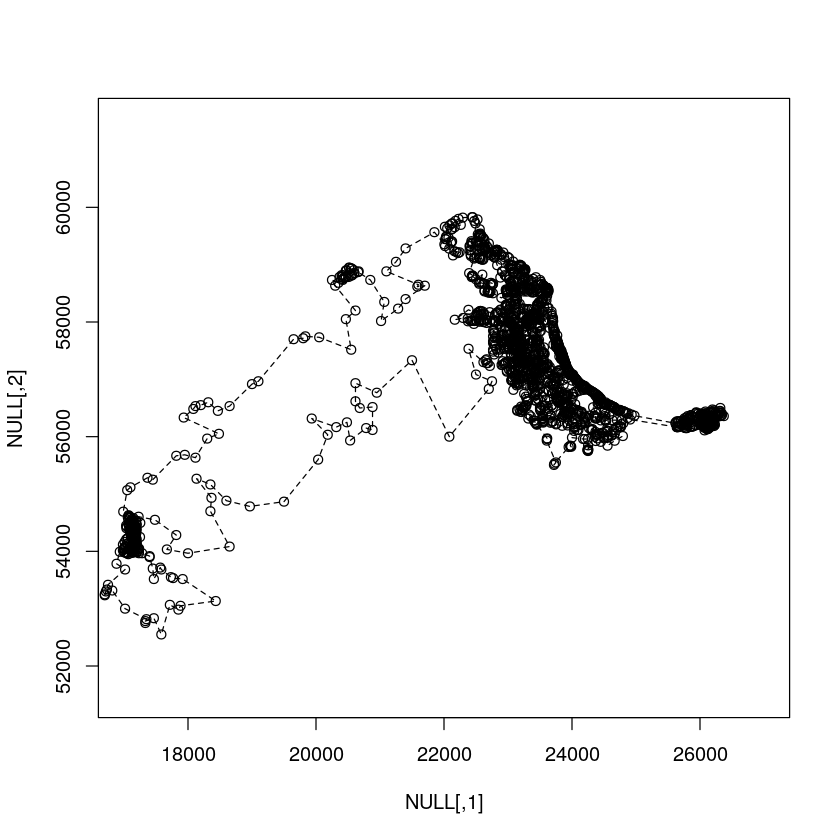

In [53]:
print("evaluation of result: ")
print("the ratio of this heuristics result over concorde result is: ")
tour_length(as.TOUR(merged_tour),dataETSP)/concorde_result

print("the absolute value of the difference between 2 results")
tour_length(as.TOUR(merged_tour),dataETSP) - concorde_result

print("the time it takes for the heuristic method is ")
total
print("the time it takes for the concorde solver is ")
concorde_time

print("this is the plot of the heuristic produced tour: ")
plot(dataETSP, as.TOUR(merged_tour),xlim=c(17000,27000), ylim=c(51500,61500))

In [72]:
library("TSP")
concorde_path("~/concorde/LINKERN")

processing_time <- list()
percentage_over <- list()

for (i in 1:10){
    start_time <- Sys.time()
    heuristic_tour <- solve_TSP(dataTSP, method="two_opt")
    end_time <- Sys.time()
    heuristic_time <- end_time-start_time
    processing_time <- append(processing_time, as.numeric(toString(heuristic_time))*60)
    percentage <- (tour_length(heuristic_tour,dataETSP)/concorde_result - 1)*100
    percentage_over <- append(percentage_over, percentage)
}

found: linkern linkern_fixed.c linkern_fixed.o linkern_path.c linkern_path.o linkern.a linkern.c linkern.o 


In [73]:
processing_time

[[1]]
[1] 142.2727

[[2]]
[1] 145.3326

[[3]]
[1] 140.0768

[[4]]
[1] 145.1676

[[5]]
[1] 143.0566

[[6]]
[1] 140.3613

[[7]]
[1] 141.926

[[8]]
[1] 141.8625

[[9]]
[1] 140.8458

[[10]]
[1] 141.4515

In [74]:
percentage_over

[[1]]
[1] 15.74874

[[2]]
[1] 16.13467

[[3]]
[1] 9.050914

[[4]]
[1] 8.860706

[[5]]
[1] 11.33266

[[6]]
[1] 9.206819

[[7]]
[1] 11.18419

[[8]]
[1] 7.051951

[[9]]
[1] 10.78596

[[10]]
[1] 10.06891